<a href="https://colab.research.google.com/github/ptenteromano/stock-analysis/blob/master/lstm_crypto_and_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
%tensorflow_version 2.x
!pip uninstall -y tensorflow
!pip install tensorflow-gpu==2.0.0-alpha0
!pip install fastquant

     |████████████████████████████████| 5.3MB 7.2MB/s 
     |████████████████████████████████| 2.0MB 45.5MB/s 
     |████████████████████████████████| 194kB 47.3MB/s 
     |████████████████████████████████| 1.5MB 40.2MB/s 
     |████████████████████████████████| 143kB 52.5MB/s 
     |████████████████████████████████| 512kB 44.6MB/s 
     |████████████████████████████████| 122kB 43.1MB/s 
     |████████████████████████████████| 143kB 54.5MB/s 
     |████████████████████████████████| 6.3MB 42.0MB/s 
     |████████████████████████████████| 419kB 50.2MB/s 
     |████████████████████████████████| 1.3MB 38.6MB/s 
     |████████████████████████████████| 296kB 47.8MB/s 
     |████████████████████████████████| 3.2MB 37.7MB/s 
     |████████████████████████████████| 7.2MB 31.5MB/s 
     |████████████████████████████████| 102kB 12.4MB/s 
     |████████████████████████████████| 645kB 37.8MB/s 
     |████████████████████████████████| 747kB 50.0MB/s 
     |████████████████████████████████| 143kB 54.

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [222]:
import datetime
from fastquant import get_crypto_data, get_stock_data
import plotly.express as px
import plotly.graph_objects as go

In [80]:
today = datetime.date.today()
yesterday = today - datetime.timedelta(days=1)
yesterday = yesterday.strftime("%Y-%m-%d")
yesterday

newCols = {"dt": "Date", "open": "Open", "high": "High", "low": "Low", "close": "Close", "volume": "Volumne"}

'2021-06-29'

In [190]:
# Data comes from:
# https://finance.yahoo.com/quote/BTC-USD/history?period1=1279314000&period2=1556053200&interval=1d&filter=history&frequency=1d
df = crypto = get_crypto_data("BTC/USDT", "2018-12-01", yesterday)
df = df.reset_index()
df = df.sort_values('dt')
df = df.rename(columns=newCols)
df.tail()
# csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/BTC-USD.csv"
# csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/AAPL.csv"
# df = pd.read_csv(csv_path, parse_dates=['Date'])

,Date,Open,High,Low,Close,Volumne
937,2021-06-25,34663.08,35500.00,31275.00,31584.45,116061.130356
938,2021-06-26,31576.09,32730.00,30151.00,32283.65,107820.375287
939,2021-06-27,32283.65,34749.00,31973.45,34700.34,96613.244211
940,2021-06-28,34702.49,35297.71,33862.72,34494.89,82222.267819
941,2021-06-29,34494.89,36600.00,34225.43,35911.73,90788.796220


In [191]:
def plot_chart(df, xCol='Date', yCol='Close'):
  # ax = df.plot(x=xCol, y=yCol);
  # ax.set_xlabel("Date")
  # ax.set_ylabel("Close Price (USD)")
  px.line(df, x=xCol, y=yCol).show()

In [192]:
plot_chart(df)

# Normalization

In [107]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [108]:
scaled_close.shape

(1307, 1)

In [109]:
np.isnan(scaled_close).any()

False

In [110]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [111]:
scaled_close = scaled_close.reshape(-1, 1)

In [112]:
np.isnan(scaled_close).any()

False

In [113]:
scaled_close.shape

(1307, 1)

# Preprocessing

In [114]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [115]:
X_train.shape

(1146, 99, 1)

In [116]:
X_test.shape

(61, 99, 1)

# Model

In [117]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

# Training

In [118]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam',
)

In [119]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.2
)

Train on 916 samples, validate on 230 samples
Epoch 1/100
916/916 [==============================] - 2s 2ms/sample - loss: 0.0028 - val_loss: 0.1952
Epoch 2/100
916/916 [==============================] - 1s 820us/sample - loss: 0.0015 - val_loss: 0.1295
Epoch 3/100
916/916 [==============================] - 1s 835us/sample - loss: 0.0027 - val_loss: 0.1318
Epoch 4/100
916/916 [==============================] - 1s 835us/sample - loss: 0.0023 - val_loss: 0.0756
Epoch 5/100
916/916 [==============================] - 1s 835us/sample - loss: 0.0019 - val_loss: 0.0668
Epoch 6/100
916/916 [==============================] - 1s 838us/sample - loss: 0.0015 - val_loss: 0.0534
Epoch 7/100
916/916 [==============================] - 1s 829us/sample - loss: 0.0012 - val_loss: 0.0802
Epoch 8/100
916/916 [==============================] - 1s 828us/sample - loss: 6.9919e-04 - val_loss: 0.0445
Epoch 9/100
916/916 [==============================] - 1s 828us/sample - loss: 5.5428e-04 - val_loss: 0.0781
Epo

In [120]:
model.evaluate(X_test, y_test)

61/61 [==============================] - 0s 580us/sample - loss: 0.0399


0.03989965544983012

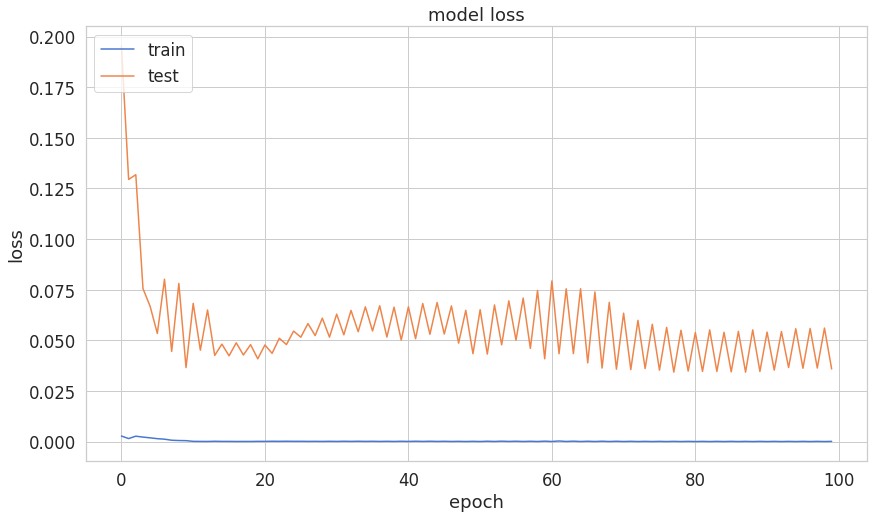

In [121]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

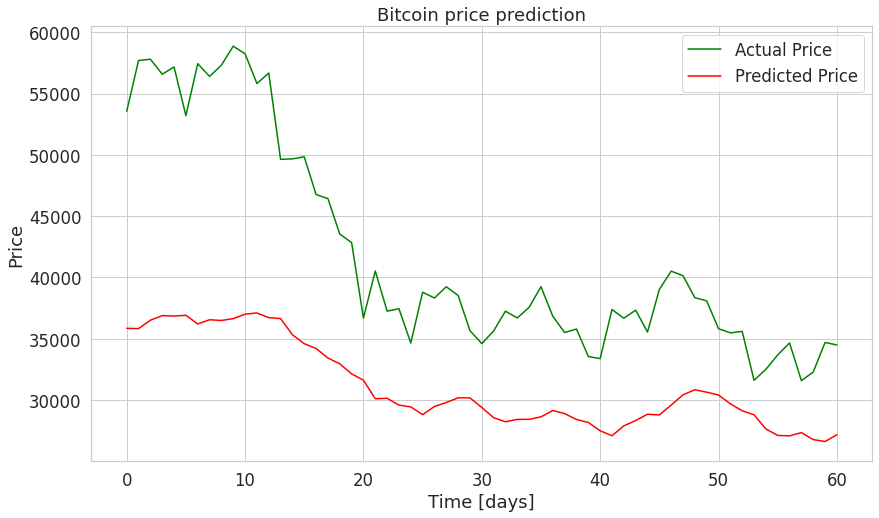

In [122]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

# Stocks

https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816


In [233]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow import keras

stock = "MGM"

stock_df = get_stock_data(stock, "2015-01-01", datetime.date.today())
stock_df = stock_df.reset_index()
stock_df = stock_df.sort_values('dt')
stock_df = stock_df.rename(columns=newCols)
stock_df.tail()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Volumne
1629,2021-06-23,42.369999,43.439999,42.320000,43.119999,6326800
1630,2021-06-24,44.150002,45.340000,44.049999,44.060001,9579500
1631,2021-06-25,44.070000,44.200001,43.730000,43.889999,7529800
1632,2021-06-28,43.650002,43.750000,41.740002,42.389999,6589100
1633,2021-06-29,42.500000,42.830002,42.049999,42.189999,4218100


In [227]:
plot_chart(stock_df)

In [229]:
close_data = stock_df['Close'].values
close_data = close_data.reshape((-1,1))

split_percent = 0.9
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = stock_df['Date'][:split]
date_test = stock_df['Date'][split:]
print(len(close_train))
print(len(close_test))

1470
164


In [230]:
look_back = 15

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [231]:

model = Sequential()
model.add(
    LSTM(10,
        activation='relu',
        input_shape=(look_back,1))
)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

num_epochs = 25
model.fit_generator(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/25
73/73 [==============================] - 7s 92ms/step - loss: 5932.0816
Epoch 2/25
73/73 [==============================] - 5s 66ms/step - loss: 823.3322
Epoch 3/25
73/73 [==============================] - 5s 66ms/step - loss: 644.9152
Epoch 4/25
73/73 [==============================] - 5s 66ms/step - loss: 493.2084
Epoch 5/25
73/73 [==============================] - 5s 69ms/step - loss: 177.3352
Epoch 6/25
73/73 [==============================] - 5s 67ms/step - loss: 18.3552
Epoch 7/25
73/73 [==============================] - 5s 66ms/step - loss: 1.9578
Epoch 8/25
73/73 [==============================] - 5s 67ms/step - loss: 1.6157
Epoch 9/25
73/73 [==============================] - 5s 66ms/step - loss: 1.3778
Epoch 10/25
73/73 [==============================] - 5s 66ms/step - loss: 1.2927
Epoch 11/25
73/73 [==============================] - 5s 66ms/step - loss: 1.1203
Epoch 12/25
73/73 [==============================] - 5s 68ms/step - loss: 1.0894
Epoch 13/25
73/73 [======

In [234]:
prediction = model.predict_generator(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = stock,
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

# Prediction

In [238]:

close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = stock_df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 10
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

In [250]:
len(forecast_dates)
forecast_dates

[Timestamp('2021-06-29 00:00:00', freq='D'),
 Timestamp('2021-06-30 00:00:00', freq='D'),
 Timestamp('2021-07-01 00:00:00', freq='D'),
 Timestamp('2021-07-02 00:00:00', freq='D'),
 Timestamp('2021-07-03 00:00:00', freq='D'),
 Timestamp('2021-07-04 00:00:00', freq='D'),
 Timestamp('2021-07-05 00:00:00', freq='D'),
 Timestamp('2021-07-06 00:00:00', freq='D'),
 Timestamp('2021-07-07 00:00:00', freq='D'),
 Timestamp('2021-07-08 00:00:00', freq='D'),
 Timestamp('2021-07-09 00:00:00', freq='D')]

In [253]:
px.line(x=forecast_dates, y=forecast)